In [2]:
import torch
import torch as th
import dgl

import dgl.function as fn

g = dgl.graph(([0, 1, 2], [3, 4, 5]))
g.ndata['h'] = th.randn((g.number_of_nodes(), 10))
g.edata['w'] = th.randn((g.number_of_edges(), 1))

g.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h_sum'))
g.update_all(fn.u_mul_e('h', 'w', 'm'), fn.mean('m', 'h_max'))

Using backend: pytorch


## Attention layer of Transformer

The **attention** layer, each node in module learns to assign weights on its incoming edges. For node pair $(i,j)$ with node $x_i,x_j \in \mathbb{R}^n$, the score of connection is as follows:

$$
q_j = W_q \cdot x_j \\
k_i = W_k \cdot x_i \\
v_i = W_v \cdot x_i \\
\text{score} = q_j k_i
$$

$W_q, W_k, W_v \in \mathbb{R}^{n \times d_k}$ map the representations of x to "query", "key", and "value" space repsectively. These values are three different linear projections of the data. For the "query" case ($W_j$), these are linear projections of source nodes for edges. For "key" and "value", were are linear projections of the destination nodes. The dot product between query source nodes and key destination nodes computes the score of the given connection.


Let's now walk through this procedure manually, and gradually move to the optimized dgl implementation. Another way to write is this procedure is

$$
\text{Attention}(Q, K, V) = \text{softmax} ( \frac{Q K^T}{\sqrt{(d_k)}} ) V
$$

In [3]:
from torch import nn
import copy
from torch.nn import functional as F
import math

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

d_k = 3
x_j = torch.randn(10, d_k) # destination nodes j
x_i = torch.randn(4, d_k)  # source nodes i
W_q, W_k, W_v, W_o = clones(nn.Linear(3, 3), 4)
q = W_q(x_j)
k = W_k(x_i)
v = W_v(x_i)
score = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
print(score.shape)
attention = torch.matmul(F.softmax(score), v)
print(attention.shape)

torch.Size([10, 4])
torch.Size([10, 3])


<ipython-input-3-04c711e75edb>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attention = torch.matmul(F.softmax(score), v)


### Multi-Head Attention

For **multi-head attention**, we compute a portion of the attention and concatenate the results. Hence attention calculations can occur in parallel. Lets again walk through this manually.

In [4]:
# say we have our three linear embeddings of query, key, and value
# it is assumed the dimensions between key and value are equivalent
q = torch.randn(10, 4, 30)
k = torch.randn(10, 3, 30)
v = torch.randn(10, 3, 30)

# Attention is generally applied with QK^TV, often with scaling and softmax applied,
# as in softmax(scaling * QK^T)V
print(torch.matmul(torch.matmul(q, k.transpose(-2, -1)), v).shape)


# to do multihead attention, we split the tensor across multiple heads
# we first calculate some dimensions
batch_size = q.size(0)
d_model = q.size(-1)
heads = 5
d_k = d_model // heads

# else we need to change our embeddings a bit
assert d_model % heads == 0

# then we split d_model across multiple heads
q_view = q.view(batch_size, -1, heads, d_k)

# we then swap the head to the non-matrix (i.e. batch) dimensions using transpose
q_view = q_view.transpose(1, 2)

# NOTE: it must be done in this was as not to juggle the values

# resulting in (batch_size, h, i, d_k)
# our aim is to sum across d_k during matrix multiplication, so that (b, h, i, d_k) * (b, h, d_k, j) -> (b, h, i, j)
# final matmul with the value results in (b, h, i, j) * (b, h, j, d_k) -> (b, h, j, d_k)
q_view = q.view(batch_size, -1, heads, d_k).transpose(1, 2)
k_view = k.view(batch_size, -1, heads, d_k).transpose(1, 2)
v_view = v.view(batch_size, -1, heads, d_k).transpose(1, 2)
    
z = torch.matmul(q_view, k_view.transpose(-2, -1))
print(z.shape)

# the attention as a specific head (e.g. batch=0, head=1) can be found using:
print(z[0, 1])

# out final values with attenion applied
a = torch.matmul(z, v_view)

# which returns us to the original shape
a.view(batch_size, -1, heads * d_k).shape

torch.Size([10, 4, 30])
torch.Size([10, 5, 4, 3])
tensor([[-0.3419, -2.0336, -1.3005],
        [ 2.2123, -1.0456, -0.3535],
        [ 1.0521,  3.1657,  1.2814],
        [ 2.3995, -1.5056,  3.1917]])


torch.Size([10, 4, 30])

## Multi-Headed Attention and Graph Transformer

We can quickly implement the initial embedding of the MultiHeadAttention. Right now, we are leaving out the more complicated forward propogation. We will walk through that implementation next.

In [8]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, h, dim_model):
        super().__init__()
        self.d_k = dim_model // h
        assert dim_model % h == 0
        self.h = h
        # W_q, W_k, W_v, W_o
        self.linears = clones(nn.Linear(dim_model, dim_model), 4)
        
    def get(self, x, fields='qkv'):
        "Return a dict of queries / keys / values."
        batch_size = x.shape[0]
        ret = {}
        if 'q' in fields:
            ret['q'] = self.linears[0](x).view(batch_size, self.h, self.d_k)
        if 'k' in fields:
            ret['k'] = self.linears[1](x).view(batch_size, self.h, self.d_k)
        if 'v' in fields:
            ret['v'] = self.linears[2](x).view(batch_size, self.h, self.d_k)
        return ret
    
    def get_output(self, x):
        "get output of the multi-head attention"
        batch_size = x.shape[0]
        return self.linears[3](x.view(batch_size, -1))

Now we will walk through the forward propogation using dgl. First, lets create a simple test graph and attach some data to the nodes.

Graph(num_nodes=5, num_edges=4,
      ndata_schemes={'q': Scheme(shape=(8,), dtype=torch.float32), 'k': Scheme(shape=(8,), dtype=torch.float32), 'v': Scheme(shape=(8,), dtype=torch.float32)}
      edata_schemes={})


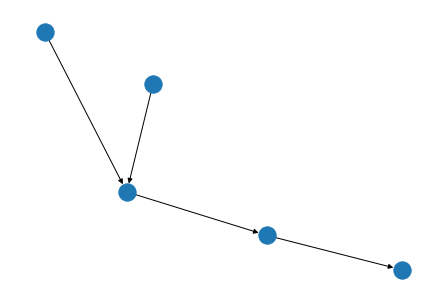

In [71]:
import dgl
import dgl.function as fn # contains all the built-in optimized message passing and reduce functions.
import networkx as nx
%matplotlib inline

g = dgl.graph(([0, 1, 2, 3], [2, 2, 3, 4]))
x = torch.randn(g.number_of_nodes(), 8)
# attn = MultiHeadAttention(2, 8)
# ret = attn.get(x)
g.ndata['q'] = torch.randn_like(x)
g.ndata['k'] = torch.randn_like(x)
g.ndata['v'] = torch.randn_like(x)

nxg = nx.DiGraph(g.to_networkx())
print(g)
nx.draw(nxg)

In [120]:
print(g.edges())

g.apply_edges(fn.v_mul_u('q', 'k', 'score'))
score = g.edata['score']
print(score[:2].sum(1))

# manually
q = g.ndata['q'][2:3]
k = g.ndata['k'][:2]
v = g.ndata['v'][:2]

mm = torch.matmul
print(mm(q, k.T))

tensor([ 0.5014, -1.8072])
(tensor([0, 1, 2, 3]), tensor([2, 2, 3, 4]))
tensor([[ 0.5014, -1.8072]])


In [139]:
# now we create a user defined function

def src_dot_dst(src_field, dst_field, out_field):
    def func(edges):
        return {out_field: (edges.src[src_field] * edges.dst[dst_field]).sum(-1, keepdim=True)}
    return func

def scaled_exp(field, scale_con)

g.apply_edges(src_dot_dst('k', 'q', 'score'))
print(g.edata['score'])

tensor([[ 0.5014],
        [-1.8072],
        [ 4.4656],
        [-2.3138]])


In [173]:
g.update_all(fn.v_mul_u('q', 'k', 'score'), fn.sum('score', 'z'))
g.update_all(fn.copy_u('z', 's'), fn.sum('s', 's'))
print(g.ndata['z'])
print(g.ndata['s'])

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.7899, -4.7639,  0.0459,  0.1546,  0.6173, -0.0286, -0.3896,  2.2687],
        [ 0.0890, -0.3561,  2.0339,  0.5506,  0.2999,  2.5642, -0.3474, -0.3684],
        [-0.1353,  0.5503, -0.8651, -0.3484, -1.1232, -0.0104,  0.7730, -1.1547]])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.7899, -4.7639,  0.0459,  0.1546,  0.6173, -0.0286, -0.3896,  2.2687],
        [ 0.0890, -0.3561,  2.0339,  0.5506,  0.2999,  2.5642, -0.3474, -0.3684]])


score[0,:]

$$
o = W_o \cdot \text{concat} ([wv^{(0)},wv^{(1)},...,wv^{(h)}])
$$

In [33]:
from torch import nn

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class MultiHeadAttention(nn.Module):
    
    def __init__(self, h, d_model):
        super().__init__()
        self.d_k = d_model // h
        self.h = h
        
        # W_q, W_k, W_v, W_o
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        
